In [91]:
# The Anchor set is all natural sequences that have proline in them
# Mod set is all seqences with the modified residue (therefore they must contain proline)
# Total valid set is union of the two sets
# Consistency (A value of 1 in hydrophilic and a value approaching 0 is hydrophilic)

In [92]:
# Add in the calculation for the root squared mean error stuff
# Fix the nomenclature on the data export it reads very oddly

In [93]:
# Single Source Folder --> reduced_file(s) + alignment talbe
# Define a directory you want all the data to output the last file path is added automaticaly

# User Defined Settings

In [94]:
COMPOUND_NAME = '4SFlp_2D'
MAKE_DIR = True # don't ever change this

IUPAC = None
CAA = 'P'
ENZYME = 'trypsin'
ORGANISM = 'e_coli_mg1655'
MASS_INJECT_UG = 1
GRAD = '90_min_0.5per_min'
PHASE1 = 'C18'
PHASE2 = 'C18'
REPLICATE = '1of1'
MASS_SHIFT = None
MIN_CONFIDENCE = -3

In [95]:
INPUT = r"C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_INPUT\S_fluoroproline_reanalysis\2023-01-25_fluoroproline_1D_alignment.csv"
OUTPUT = r"C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results"

# Dependencies

In [96]:
# The usual imports
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import scipy
import math

# File namming, timming and export
import datetime
import time
import os

# Extra plotting options
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib_venn import venn2, venn2_circles, venn3
from matplotlib import figure
%matplotlib inline

# Set Up the Data Export Location

In [97]:
if MAKE_DIR:
    compound_dir = os.path.join(OUTPUT,f'{COMPOUND_NAME}')
    os.makedirs(compound_dir)                                  # Make a directory for the compound

    os.makedirs(os.path.join(compound_dir,'chroma_data'))      # Make a subdirectory for the data
    data_path = os.path.join(compound_dir,'chroma_data')

    os.makedirs(os.path.join(compound_dir,'chroma_figures'))   # Make a subdirectory for the figures
    figure_path = os.path.join(compound_dir,'chroma_figures')

print(compound_dir)
print(data_path)
print(figure_path)

C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results\4SFlp_2D
C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results\4SFlp_2D\chroma_data
C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results\4SFlp_2D\chroma_figures


# Pandas Settings, Matplot Settings, DATE

In [98]:
# This has to go after the dependencies
time_stamp = datetime.datetime.now()
DATE = time_stamp.strftime("%Y-%m-%d")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None )

# Plotting settings
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2

print(DATE)

2023-02-27


# Load the Alignment Table & Set HI values

In [99]:
alignment_df = pd.read_csv(INPUT).set_index('compound_ptm')
alignment_df

,p2_min,p3_min,p4_min,p5_min,p6_min,file_path_reduced
compound_ptm,,,,,,
4SFlp_1,23.770000,33.770000,44.240000,54.990000,61.25000,C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_INPUT\S_fluoroproline_reanalysis\JA2023FPLS1-reduced.txt
4SFlp_2,23.800000,33.590000,44.020000,54.730000,60.91000,C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_INPUT\S_fluoroproline_reanalysis\JA2023FPLS2-reduced.txt
4SFlp_2D,22.857666,32.645655,42.627918,53.314196,59.31666,C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_INPUT\S_fluoroproline_reanalysis\True_SfluoroProline_2D_Run.txt


In [100]:
SIX_P_RT_MIN = alignment_df.loc[COMPOUND_NAME][['p2_min', 'p3_min', 'p4_min', 'p5_min', 'p6_min']]
HI_CALIBRATION = [4.58, 8.55, 13.08, 18.26, 21.59] # Peptide Retention Standards and ... 2009, Formic Acid C18, 100A
REDUCED_PATH = alignment_df.loc[COMPOUND_NAME]['file_path_reduced']

# Retention Time Calibration

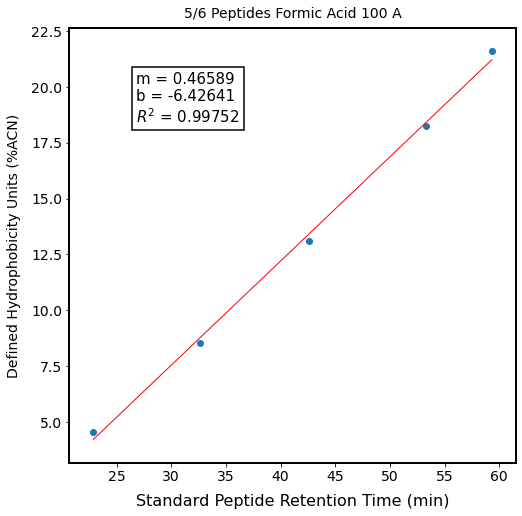

In [101]:
# I should pack this the way I usually do !
x_vals = SIX_P_RT_MIN
y_vals = HI_CALIBRATION

# Regression Line (x,y,order) --> (m,b)
line_m_b = np.polyfit(x_vals.to_list(), y_vals, 1)

def linearRegressHi(observed_retention_min):
    rt_hi = line_m_b[0]*observed_retention_min + line_m_b[1]
    return rt_hi

# Calculate the least squares regression input ([y],[f(x)])
correlation = r2_score(y_vals, x_vals.apply(linearRegressHi).tolist())

#Store Prediction Coefficients
calib_params = tuple((line_m_b[0], line_m_b[1], correlation))

# The plotting starts here
fig_calib_params, ax = plt.subplots(figsize=(8,8))
plt.scatter(x_vals.tolist(), y_vals)
plt.plot(x_vals.tolist(), x_vals.apply(linearRegressHi).tolist(), 'red', linewidth=1)

# Styling
ax.set_xlabel('Standard Peptide Retention Time (min)', fontsize=16, labelpad=10)
ax.set_ylabel('Defined Hydrophobicity Units (%ACN)', fontsize=14, labelpad=10)
ax.set_title(f"5/6 Peptides Formic Acid 100 A",  pad=10, fontsize=14)
ax.set_xmargin(0.06)
ax.set_ymargin(0.06)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
text = f'm = {calib_params[0]:.5f}\nb = {calib_params[1]:.5f}\n$R^2$ = {calib_params[2]:.5f}'
plt.text(0.15, .90, text, ha='left', va='top', transform=ax.transAxes, fontsize=15, bbox=dict( facecolor='white', edgecolor="black", linewidth=1.5));

# Save it
fig_calib_params.savefig(os.path.join(figure_path, f'{DATE}_calibration_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Load, Clean, Split, Drop

In [102]:
# Load
df = pd.read_csv(REDUCED_PATH, sep=' ')
df.columns = ['type', 'seq', 'id', 'charge', 'mH_obs', 'mH_the', 'conf', 'ssr_new', 'rt_min', 'ssr_old', 'frac', 'intensity']

In [103]:
sixp = ['LGGGGGGDGSR', 'LGGGGGGDFR', 'LLGGGGDFR', 'LLLGGDFR', 'LLLLDFR', 'LLLLLDFR']
df.loc[df['seq'].isin(sixp)].sort_values(by=['rt_min'])

,type,seq,id,charge,mH_obs,mH_the,conf,ssr_new,rt_min,ssr_old,frac,intensity


In [104]:
# Clean

# Overwrite cysteine alkylation, example C:0:57.02147, or C:20:57.02147 there could be a ~ right after, possible
pattern = r'C:\d+:\d\d.\d\d\d\d\d~?'
df.replace(to_replace = pattern, value = '', regex = True, inplace = True)

# A simple counting function, proabaly not the fastest, used to get num_mods
def letterCounter(string):
    count = 0
    valid_amino = ['A', 'R', 'N', 'D', 'C',
                   'Q', 'E', 'G', 'H', 'I',
                   'L', 'K', 'M', 'F', 'P',
                   'S', 'T', 'W', 'Y', 'V']
    for aa in string:
        if aa in valid_amino:
            count += 1
    return count

In [105]:
# Split
df[['seq','mods']] = df['seq'].str.split("^", expand=True)
df[['id', 'm/z']] = df['id'].str.split("~", expand=True)
df['m/z'] = df['m/z'].astype(float)
df['seq_len'] = df['seq'].apply(len)
df['num_mods'] = df['mods'].apply(letterCounter) 

# add in ppm error
df['ppm_error'] = abs((df['mH_obs'] - df['mH_the']) / df['mH_the'] * 1_000_000 )
filt = df['ppm_error'] != 0 
df['log10_ppm_error'] = df['ppm_error'][filt].apply(np.log10)

# Calibrate to HI units
df['rt_hi'] = df['rt_min'].apply(linearRegressHi)  # add in the HI values
df['ssr_new_hi'] = df['ssr_new'].apply(linearRegressHi)

In [106]:
# Drop
df.drop(['frac', 'ssr_old'], axis=1, inplace=True)

# Visualize MS Spray

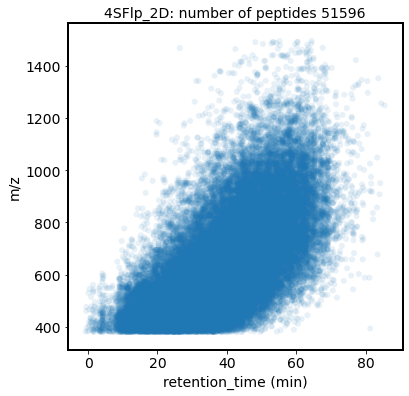

In [107]:
# The plotting starts here
fig_mz_rt_cloud, ax = plt.subplots(figsize=(6,6))
ax.scatter(df['rt_min'], df['m/z'], edgecolors='none', alpha = 0.1)


# Styling
ax.set_title(f"{COMPOUND_NAME}: number of peptides {df['seq'].count()}", fontsize=14)
ax.set_xlabel('retention_time (min)', fontsize=14);
ax.set_ylabel('m/z', fontsize=14);
ax.set_xmargin(0.06)
ax.set_ymargin(0.06)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Save it
fig_mz_rt_cloud.savefig(os.path.join(figure_path, f'{DATE}_ms_spray_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Distribution of hydrophobicity

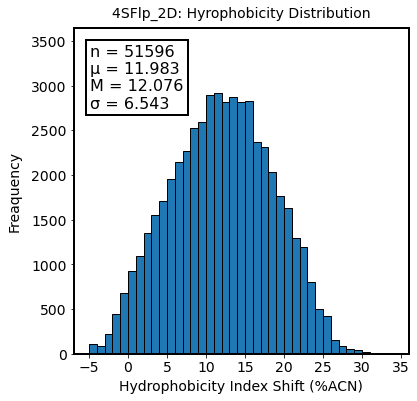

In [108]:
# This actually makes the plot
fig_hi_distrib, ax = plt.subplots(figsize=(6,6))
ax.hist(df['rt_hi'], bins=np.arange(-5,35, 1), edgecolor = 'k') # start with simple df[].hist()

# Single variable statistics
mean_hi = df['rt_hi'].mean()
median_hi = df['rt_hi'].median()
std_hi= df['rt_hi'].std()

# Styling
ax.set_xlabel('Hydrophobicity Index Shift (%ACN)', fontsize=14, labelpad=5)
ax.set_title(f"{COMPOUND_NAME}: Hyrophobicity Distribution",  pad=10, fontsize=14)
ax.set_ylabel('Freaquency', fontsize=14, labelpad=10 )
ax.set_xmargin(0.05)
ax.set_ymargin(0.25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

text = f'n = {df.shape[0]}\nμ = {mean_hi:.3f}\nM = {median_hi:.3f}\nσ = {std_hi:.3f}'
plt.text(0.05, .95, text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict( facecolor='white', edgecolor="black", linewidth=2));

# Save it
fig_hi_distrib.savefig(os.path.join(figure_path, f'{DATE}_hi_histogram_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Confidence Distribution

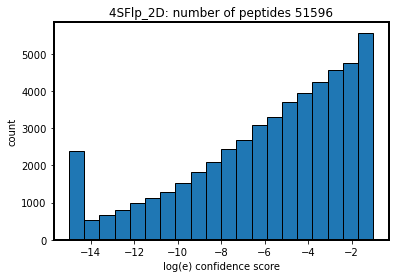

In [109]:
# Note that from this graph it appears that X!Tandem has internal -1 cuttoff
df['conf'].hist(bins=20, grid=False, edgecolor='k')
plt.title(f"{COMPOUND_NAME}: number of peptides {df['seq'].count()}")
plt.ylabel('count')
plt.xlabel('log(e) confidence score');

# Visualize MonoIsotope and First Isotope

Text(0.5, 0, 'log10(ppm Error)')

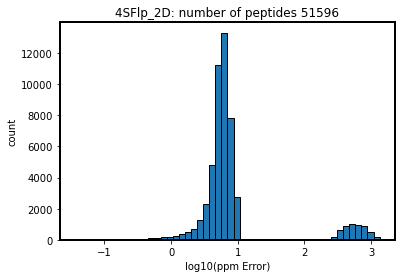

In [110]:
# Distribution of peptide ppm errors I should but the non-logged besides it
# The second little peak here is the first isotopic mass !
df['log10_ppm_error'].hist(bins=50, grid=False, edgecolor='k')
plt.title(f"{COMPOUND_NAME}: number of peptides {df['seq'].count()}");
plt.ylabel('count')
plt.xlabel('log10(ppm Error)')

# Machine Param Filters !

In [111]:
# Store Original Number for Posterity
gross_peptide_id = df.shape[0]
gross_mod_id = df['mods'].str.contains(CAA).sum()
filt = df['conf'] < MIN_CONFIDENCE
df = df[filt]
df.drop('log10_ppm_error', axis=1, inplace=True)

# Peptide Parameters

In [112]:
num_seqs = df.shape[0]
num_seqs_unique = len(df['seq'].unique()) # length of array is therfore number of unique
num_mod_seqs = df['mods'].str.contains(CAA).sum()

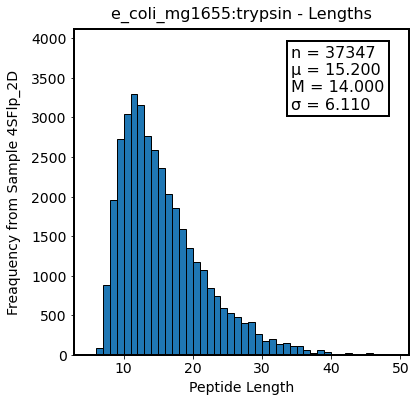

In [113]:
# This actually makes the plot
fig_len_distrib, ax = plt.subplots(figsize=(6,6))
ax.hist(df['seq_len'], bins=np.arange(5,50, 1), edgecolor = 'k') # start with simple df[].hist()

# Single variable statistics
mean_len = df['seq_len'].mean()
median_len = df['seq_len'].median()
std_len = df['seq_len'].std()

# Styling
ax.set_title(f"{ORGANISM}:{ ENZYME} - Lengths",  pad=10, fontsize=16)
ax.set_xlabel('Peptide Length', fontsize=14, labelpad=5)
ax.set_ylabel(f'Freaquency from Sample {COMPOUND_NAME}', fontsize=14, labelpad=10 )
ax.set_xmargin(0.05)
ax.set_ymargin(0.25)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

text = f'n = {df.shape[0]}\nμ = {mean_len:.3f}\nM = {median_len:.3f}\nσ = {std_len:.3f}'
plt.text(0.65, .95, text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict( facecolor='white', edgecolor="black", linewidth=2));

# Save it
fig_len_distrib.savefig(os.path.join(figure_path, f'{DATE}_length_histogram_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Amino Acid Parameters

In [114]:
# Define Functions
def SumLenListOStr(series):
    total = 0
    for i in series:
            total += len(i)
    return total

def NumCharListOStr(series, aa):
    count = 0
    for peptide in series:
        count += peptide.count(aa)
    return count

def AminoAcidFreq(series):
    aa_freq = {'A':0, 'R':0, 'N':0, 'D':0, 'C':0,
               'Q':0, 'E':0, 'G':0, 'H':0, 'I':0,
               'L':0, 'K':0, 'M':0, 'F':0, 'P':0,
               'S':0, 'T':0, 'W':0, 'Y':0, 'V':0}
    
    for peptide in series:
        for aa in peptide:
            if aa in aa_freq.keys():
                aa_freq[aa] += 1
    return aa_freq

In [115]:
# Total Ammounts of Indetified Amino acids
num_aa = SumLenListOStr(df['seq'])
num_aa_unique = SumLenListOStr(df['seq'].unique())

# Distribution of Amino Acids in the Sample stored as dictionaries
aa_freq = AminoAcidFreq(df['seq'])
aa_freq_unique = AminoAcidFreq(df['seq'].unique())

# seq with ncAA Parameters

In [116]:
# Needs to be adjusted for spectral count !!!!!
# Note direct obesrvation of spectra is biased for the seq with ncAA aa
# Use direct results to get %I, then apply this back to the unique values
num_caa = aa_freq[CAA] # Count of total Proline
num_ncaa = df['mods'].str.count(CAA).sum() # P:5:11.99997 this approach shold be based off the mass shift !
percent_seq_ncaa = (num_ncaa /num_caa) * 100  # Time for that percent seq with ncAA

In [117]:
# Make an amino acid distribution DataFrame for the entire sample
def MakePercentAa(number):
    percent = (number / num_aa) * 100
    return percent

aa_distrib = pd.DataFrame(aa_freq, index=['count']).transpose()
aa_distrib.sort_values(by=['count'], ascending=False, inplace=True)
aa_distrib['percent'] = aa_distrib['count'].apply(MakePercentAa).round(decimals=2)
aa_distrib.reset_index(inplace=True)

# Make an amino acid distribution DataFrame based off the unique sequences
def MakePercentAaUnique(number):
    percent = (number / num_aa_unique) * 100
    return percent

aa_distrib_unique = pd.DataFrame(aa_freq_unique, index=['count']).transpose()
aa_distrib_unique.sort_values(by=['count'], ascending=False, inplace=True)
aa_distrib_unique['percent'] = aa_distrib_unique['count'].apply(MakePercentAaUnique).round(decimals=2)
aa_distrib_unique.reset_index(inplace=True)

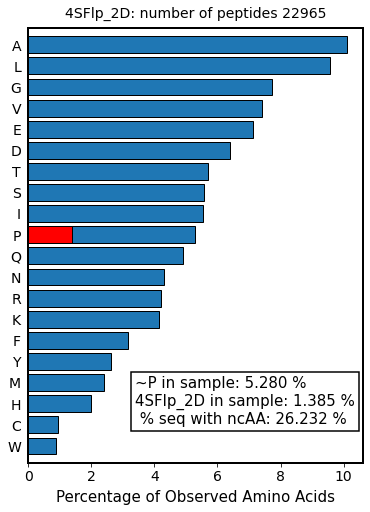

In [118]:
# Plot the Amino Acid distribution based only off the unique values
fig_aa_distrib_unique, ax = plt.subplots(figsize=(6,8))

y_groups = aa_distrib_unique['index'].to_list()
y_pos = range(len(y_groups))
x_vals = aa_distrib_unique['percent'].to_list()

# The reverse method modifies the results in place
x_vals.reverse()
y_groups.reverse()



"""Make an overlay for thepercentage of the ncaa in the proteome"""
percent_caa = aa_distrib_unique[aa_distrib_unique['index'] == CAA]['percent'].to_list()[0]                    # What percent of the observed AA where proline
percent_ncaa = aa_distrib_unique[aa_distrib_unique['index'] == CAA]['percent'].to_list()[0] * (percent_seq_ncaa/100) # Color Prolines with %I

percent_seq_ncaa_overlay = np.zeros(20)
caa_pos = y_groups.index(CAA)
percent_seq_ncaa_overlay[caa_pos] = percent_ncaa

# The Actual Plotting is Here
ax.barh(y_groups, x_vals, align='center', edgecolor='k') # Bar Plot of the Total Amino Acid Distribution
ax.barh(y_groups, percent_seq_ncaa_overlay, align='center', edgecolor='k', color='red') # Bar Plot for the ncaa overlay


#Style
ax.set_xlabel('Percentage of Observed Amino Acids', fontsize=15, labelpad=6)
plt.title(f"{COMPOUND_NAME}: number of peptides {num_seqs_unique }",  pad=10, fontsize=14)
ax.set_xmargin(0.05)
ax.set_ymargin(0.02)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(left = False)

text = f'~{CAA} in sample: {percent_caa:.3f} %\n{COMPOUND_NAME} in sample: {percent_ncaa:.3f} %\n % seq with ncAA: {percent_seq_ncaa:.3f} %'
plt.text(0.32, 0.2, text, ha='left', va='top', transform=ax.transAxes, fontsize=15, bbox=dict( facecolor='white', edgecolor="black", linewidth=1.5));

# Save it
fig_aa_distrib_unique.savefig(os.path.join(figure_path, f'{DATE}_fig_aa_distrib_unique_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

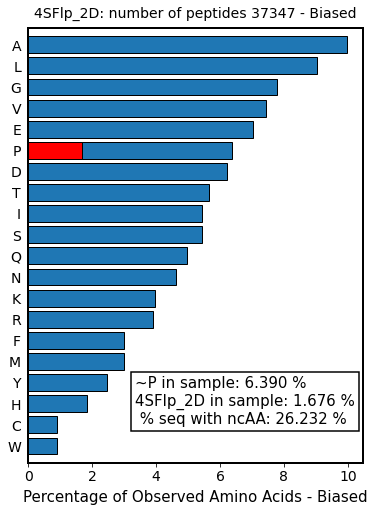

In [119]:
## Plot the amino acid distribution for the entire sample
## Chnange This to be a Simple overlay of the Unique
fig_aa_distrib, ax = plt.subplots(figsize=(6,8))

y_groups = aa_distrib['index'].to_list()
y_pos = range(len(y_groups))
x_vals = aa_distrib['percent'].to_list()
x_vals.reverse()
y_groups.reverse()

"""Make an overlay for the absolute percentage of the ncaa in the proteome"""
percent_caa = aa_distrib[aa_distrib['index'] == CAA]['percent'].to_list()[0]                       # What percent of the observed AA where proline
percent_ncaa = aa_distrib[aa_distrib['index'] == CAA]['percent'].to_list()[0] * (percent_seq_ncaa/100) # What is the total percentage of modified proline

percent_seq_ncaa_overlay = np.zeros(20)
caa_pos = y_groups.index(CAA)
percent_seq_ncaa_overlay[caa_pos] = percent_ncaa

# The actual graph starts here
ax.barh(y_groups, x_vals, align='center', edgecolor='k')                         # Bar Plot of the Total Amino Acid Distribution
ax.barh(y_groups, percent_seq_ncaa_overlay, align='center', edgecolor='k', color='red') # Bar Plot for the ncaa overlay


#Style
ax.set_xlabel('Percentage of Observed Amino Acids - Biased', fontsize=15, labelpad=6)
plt.title(f"{COMPOUND_NAME}: number of peptides {df['seq'].count()} - Biased",  pad=10, fontsize=14)
ax.set_xmargin(0.05)
ax.set_ymargin(0.02)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(left = False)

text = f'~{CAA} in sample: {percent_caa:.3f} %\n{COMPOUND_NAME} in sample: {percent_ncaa:.3f} %\n % seq with ncAA: {percent_seq_ncaa:.3f} %'
plt.text(0.32, 0.2, text, ha='left', va='top', transform=ax.transAxes, fontsize=15, bbox=dict( facecolor='white', edgecolor="black", linewidth=1.5));

# Save it !
fig_aa_distrib.savefig(os.path.join(figure_path, f'{DATE}_fig_aa_distrib_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Filter and Make the delta HI 

In [120]:
# The first two together serve to srub oxidations, deamidations, and multiple seq with ncAA
cond3 = df['num_mods'] == 0
cond4 = df['num_mods'] == 1 & df['mods'].str.contains(CAA)

# Only accept things which are retained for chromatographic analysis
cond5 = df['rt_hi'] > 0

option1 = (cond3 & cond5)
option2 = (cond4 & cond5)
filt = (option1 | option2)

# New filtred dataFrame
filtered_df = df[filt]

# Take out every sequence with no mods
anchor_df = filtered_df[filtered_df['num_mods'] == 0]

# Take out all the sequences with mods
modded_df = filtered_df[filtered_df['num_mods'] == 1]

# delta df is an inner join
delta_df = pd.merge(anchor_df,modded_df,on='seq', how='inner')

# Be the regular sequences are x and the modded ones are y
delta_df['delta_rt_min'] = delta_df['rt_min_y'] - delta_df['rt_min_x']
delta_df['delta_hi'] = delta_df['rt_hi_y'] - delta_df['rt_hi_x']
delta_df.reset_index(drop=True, inplace=True)

########################################################################################################
# Confirm the mass shift as a separate column should do this earlier... 
delta_df['mass_shift'] = delta_df['mods_y'].str.extract(r':(\-?\d\d?\d?.\d\d\d\d\d?)').astype('float')
#########################################################################################################
# But this will require you to define mass mod in the user inputs and change some of the program logic

delta_df.head(1)

,type_x,seq,id_x,charge_x,mH_obs_x,mH_the_x,conf_x,ssr_new_x,rt_min_x,intensity_x,mods_x,m/z_x,seq_len_x,num_mods_x,ppm_error_x,rt_hi_x,ssr_new_hi_x,type_y,id_y,charge_y,mH_obs_y,mH_the_y,conf_y,ssr_new_y,rt_min_y,intensity_y,mods_y,m/z_y,seq_len_y,num_mods_y,ppm_error_y,rt_hi_y,ssr_new_hi_y,delta_rt_min,delta_hi,mass_shift
0,4,AQQSPYSAAMAEQR,1.1.12.646.2,2,1537.7189,1537.706,-10.1,18.54,30.059426,2.023559e+06,"""""",769.3635,14,0,8.38912,7.577989,2.211197,5,1.1.15.7887.2,2,1555.704,1555.6969,-4.7,18.54,30.986083,4.557931e+06,P:4:17.99055,778.356,14,1,4.563871,8.00971,2.211197,0.926657,0.431721,17.99055


In [121]:
mean_natural_hi = anchor_df['rt_hi'].mean()
mean_natural_len = anchor_df['seq_len'].mean()
print(f'Mean natural hi: {mean_natural_hi}')
print(f'Mean natural length: {mean_natural_len}')


mean_modded_hi = modded_df['rt_hi'].mean()
mean_modded_len = modded_df['seq_len'].mean()
print(f'Mean modded hi: {mean_modded_hi}')
print(f'Mean modded length: {mean_modded_len}')

Mean natural hi: 12.613446545503804
Mean natural length: 14.42391724671307
Mean modded hi: 13.883476014793722
Mean modded length: 16.502542521479924


# Take Stock of the Filtering

In [122]:
# Recall
# gross_peptide_id
# gross_mod_id

gross_no_mod_id = gross_peptide_id - gross_mod_id
print(f'gross_peptide_id: {gross_peptide_id}') # Total peptide IDs
print(f'gross_no_mod_id: {gross_no_mod_id}') #Total Nautural Sequences
print(f'gross_mod_id: {gross_mod_id}') # Total Pairs potential
print('')


# Recall num_mod_seqs
num_natural_seqs = num_seqs - num_mod_seqs
print(f'num_seqs: {num_seqs}')   # Total after confidence filter
print(f'num_natural: {num_natural_seqs}')   # Total nat seqs after confidence
print(f"num_mods_filtered: {num_mod_seqs}") # Total mod seqs after confidence loss
print('')


# You need to define some intersection stuff first
mod_set = modded_df.shape[0]
valid_pairs = delta_df.shape[0]
pair_recovery = valid_pairs / mod_set



anchor_set = anchor_df['seq'].str.contains(CAA).sum()
total_valid_set = anchor_set + mod_set - valid_pairs
# intersection / union
percent_paired = (valid_pairs / total_valid_set) * 100

print(f'anchor_set: {anchor_set}')
print(f'mod_set: {mod_set}')
print(f'total_valid_set: {total_valid_set}')
print(f'intersection / union times one hundred: {percent_paired}')

# A table figure would be convinent here but oh well

gross_peptide_id: 51596
gross_no_mod_id: 40917
gross_mod_id: 10679

num_seqs: 37347
num_natural: 29478
num_mods_filtered: 7869

anchor_set: 10642
mod_set: 5703
total_valid_set: 11245
intersection / union times one hundred: 45.35349044019564


valid_pairs: 5100
pair recovery: 0.89


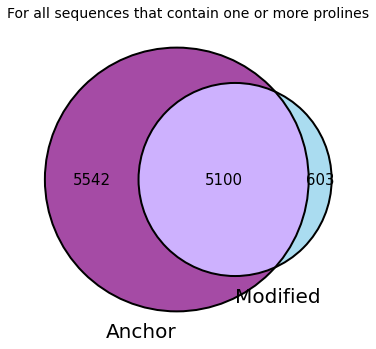

In [123]:
# Mod set contains redundant sequences do to the possiblity of seq with ncAA at different positions
data = (anchor_set  - valid_pairs, mod_set - valid_pairs, valid_pairs);

# Makes the plot
plt.figure(figsize=(6,6))

fig_overlap = venn2(subsets = data, set_labels = ('Anchor', 'Modified') , set_colors=('Purple', 'skyblue',), alpha = 0.7);
venn2_circles(subsets = data);

# Style time
plt.title('For all sequences that contain one or more prolines', fontsize=14)
for text in fig_overlap.set_labels:
    text.set_fontsize(20)
    
for text in fig_overlap.subset_labels:
    text.set_fontsize(15)


print(f'valid_pairs: {valid_pairs}')
print(f'pair recovery: {round(pair_recovery,2)}')
    
plt.savefig(os.path.join(figure_path, f'{DATE}_overlap_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Histogram of the RT shift

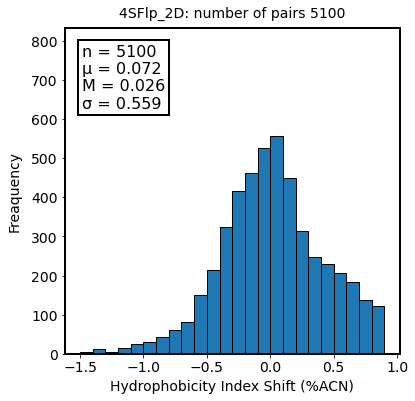

In [124]:
# This actually makes the plot
fig_delta_hi_distrib, ax = plt.subplots(figsize=(6,6))
ax.hist(delta_df['delta_hi'], bins=np.arange(-1.5, 1, 0.1), edgecolor = 'k') # start with simple df[].hist()

# Single variable s2tatistics
mean_delta_hi = delta_df['delta_hi'].mean()
median_delta_hi = delta_df['delta_hi'].median()
std_delta_hi = delta_df['delta_hi'].std()

# Styling
ax.set_xlabel('Hydrophobicity Index Shift (%ACN)', fontsize=14, labelpad=5)
ax.set_title(f"{COMPOUND_NAME}: number of pairs {valid_pairs}",  pad=10, fontsize=14)
ax.set_ylabel('Freaquency', fontsize=14, labelpad=10 )
ax.set_xmargin(0.05)
ax.set_ymargin(0.50)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

text = f'n = {valid_pairs}\nμ = {mean_delta_hi:.3f}\nM = {median_delta_hi:.3f}\nσ = {std_delta_hi:.3f}'
plt.text(0.05, .95, text, ha='left', va='top', transform=ax.transAxes, fontsize=16, bbox=dict( facecolor='white', edgecolor="black", linewidth=2));

# Save it !
fig_delta_hi_distrib.savefig(os.path.join(figure_path, f'{DATE}_delta_hi_histogtram_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

## Delta Across Lengths

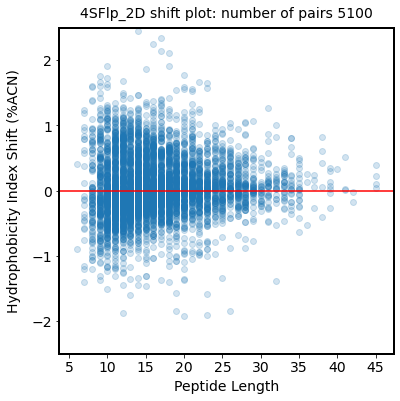

In [125]:
# This actually makes the plot
fig_delta_hi_v_len, ax = plt.subplots(figsize=(6,6))
plt.scatter(delta_df['seq_len_x'].tolist(), delta_df['delta_hi'].tolist(), alpha=0.2)  
plt.axhline(y = 0, color = 'r', linestyle = '-')                                       # Adds the horizontal Redline


# Styling
ax.set_xlabel('Peptide Length', fontsize=14, labelpad=5)
ax.set_ylabel('Hydrophobicity Index Shift (%ACN)', fontsize=14, labelpad=10)
ax.set_title(f"{COMPOUND_NAME} shift plot: number of pairs {valid_pairs}",  pad=10, fontsize=14)
ax.set_xmargin(0.06)
ax.set_ymargin(0.06)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Optional Data Filter, save outliers for correlation graphs !
plt.ylim([-2.5,2.5]);

# Save it !
fig_delta_hi_v_len.savefig(os.path.join(figure_path, f'{DATE}_shift_plot_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

## HI Modified vs HI Non Modified

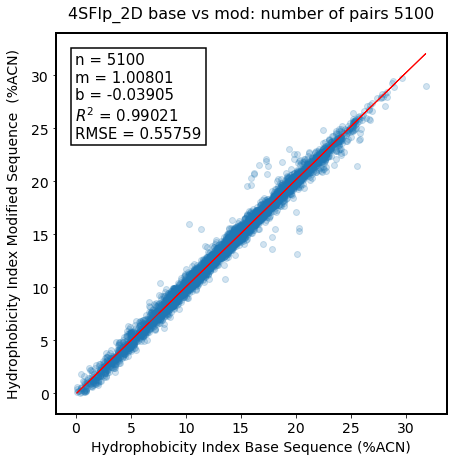

In [126]:
x_vals = delta_df['rt_hi_x']
y_vals = delta_df['rt_hi_y'].tolist()

# Regression Line (x,y,order) --> (m,b)
line_m_b = np.polyfit(x_vals.to_list(), y_vals, 1)


def linearPredict(observed_x):
    predicted = line_m_b[0] * observed_x + line_m_b[1]
    return predicted

# Calculate the least squares regression input ([y],[f(x)])
correlation = r2_score(y_vals, x_vals.apply(linearPredict).tolist())

# Calculate the root-mean-square error (RMSE); input ([y], [f(x)])
mse = mean_squared_error(y_vals, x_vals.apply(linearPredict).tolist())
rmse = math.sqrt(mse)

#Store Prediction Coefficients
mod_v_norm_params = tuple((line_m_b[0], line_m_b[1], correlation))

# The plotting starts here
fig_mod_v_norm, ax = plt.subplots(figsize=(7,7))
plt.scatter(x_vals.tolist(), y_vals, alpha=0.2)
plt.plot(x_vals.tolist(), x_vals.apply(linearPredict).tolist(), 'red', linewidth=1)
                                      
# Styling
ax.set_xlabel('Hydrophobicity Index Base Sequence (%ACN)', fontsize=14, labelpad=5)
ax.set_ylabel('Hydrophobicity Index Modified Sequence  (%ACN)', fontsize=14, labelpad=10)
ax.set_title(f"{COMPOUND_NAME} base vs mod: number of pairs {valid_pairs}",  pad=15, fontsize=16)
ax.set_xmargin(0.06)
ax.set_ymargin(0.06)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

text = f'n = {valid_pairs}\nm = {mod_v_norm_params[0]:.5f}\nb = {mod_v_norm_params[1]:.5f}\n$R^2$ = {mod_v_norm_params[2]:.5f}\nRMSE = {rmse:.5f}'
plt.text(0.05, .95, text, ha='left', va='top', transform=ax.transAxes, fontsize=15, bbox=dict( facecolor='white', edgecolor="black", linewidth=1.5));

# Save it !
fig_mod_v_norm.savefig(os.path.join(figure_path, f'{DATE}_mod_vs_norm_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

## SSRcalc Prediction vs HI Modified  

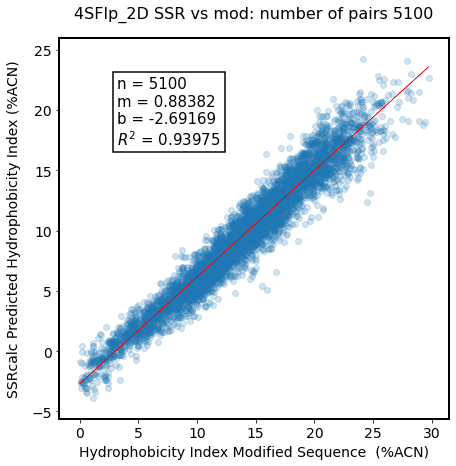

In [127]:
x_vals = delta_df['rt_hi_y']
y_vals = delta_df['ssr_new_hi_y'].tolist()

# Regression Line (x,y,order) --> (m,b)
line_m_b = np.polyfit(x_vals.to_list(), y_vals, 1)


def linearPredict(observed_x):
    predicted = line_m_b[0] * observed_x + line_m_b[1]
    return predicted

# Calculate the least squares regression input ([y],[f(x)])
correlation = r2_score(y_vals, x_vals.apply(linearPredict).tolist())

#Store Prediction Coefficients
ssr_v_mod_params = tuple((line_m_b[0], line_m_b[1], correlation))

# The plotting starts here
fig_ssr_v_mod, ax = plt.subplots(figsize=(7,7))
plt.scatter(x_vals.tolist(), y_vals, alpha=0.2)
plt.plot(x_vals.tolist(), x_vals.apply(linearPredict).tolist(), 'red', linewidth=0.50)

                                      
# Styling
ax.set_xlabel('Hydrophobicity Index Modified Sequence  (%ACN)', fontsize=14, labelpad=5)
ax.set_ylabel('SSRcalc Predicted Hydrophobicity Index (%ACN)', fontsize=14, labelpad=10)
ax.set_title(f"{COMPOUND_NAME} SSR vs mod: number of pairs {valid_pairs}",  pad=20, fontsize=16)
ax.set_xmargin(0.06)
ax.set_ymargin(0.06)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

text = f'n = {valid_pairs}\nm = {ssr_v_mod_params[0]:.5f}\nb = {ssr_v_mod_params[1]:.5f}\n$R^2$ = {ssr_v_mod_params[2]:.5f}'
plt.text(0.15, .90, text, ha='left', va='top', transform=ax.transAxes, fontsize=15, bbox=dict( facecolor='white', edgecolor="black", linewidth=1.5));

# Save it !
fig_ssr_v_mod.savefig(os.path.join(figure_path, f'{DATE}_ssr_vs_mod_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.png'))

# Top 10 Hydrophobic Shifts

In [128]:
print(COMPOUND_NAME)
hydrophobic_shift = delta_df.nlargest(15, 'delta_hi')
hydrophobic_shift[['seq',  'delta_hi', 'rt_hi_x', 'mods_y', 'conf_x', 'conf_y', 'ppm_error_x', 'ppm_error_y']]

4SFlp_2D


,seq,delta_hi,rt_hi_x,mods_y,conf_x,conf_y,ppm_error_x,ppm_error_y
4702,FVNLPPEAPR,5.730095,10.246248,P:8:17.99055,-7.9,-6.3,881.433389,3.369007
3724,FLAETDQGPVPVEITAVEDDHVVVDGNHMLAGQNLK,4.848363,17.261250,P:8:17.99055,-15.0,-7.2,268.487968,7.353146
2883,YPDHLIIGSDQVCVLDGEITGKPLTEENAR,4.834775,16.664106,P:1:17.99055,-15.0,-9.4,8.294275,8.368966
3723,FLAETDQGPVPVEITAVEDDHVVVDGNHMLAGQNLK,4.675361,17.261250,P:10:17.99055,-15.0,-13.8,268.487968,6.527530
4095,MQTPHILIVEDELVTR,4.537175,16.219287,P:3:17.99055,-14.4,-15.0,6.810946,8.211293
4957,NIPVELHVLLNDDAETPTR,4.462712,16.236793,P:16:17.99055,-9.6,-10.7,7.455336,7.393360
1359,LVHIPEEELLPGLEK,4.403798,15.937895,P:10:17.99055,-6.2,-5.6,4.603843,7.266654
2376,ANPWQQFAETHNK,4.124552,11.395127,P:2:17.99055,-8.2,-5.1,4.583828,634.406098
535,GNPTVEAEVHLEGGFVGMAAAPSGASTGSR,4.017390,15.587611,P:2:17.99055,-15.0,-6.0,4.481231,4.696716
3132,EMFREDEPMPLTSGEFAVLK,4.008628,17.463534,P:7:17.99055,-8.6,-7.5,7.265352,7.038949


In [129]:
filt = delta_df['delta_hi'] > 0
num_hydrophobic = delta_df[filt]['delta_hi'].shape[0]
sum_hydrophobic = delta_df[filt]['delta_hi'].sum()
mean_hydrophobic = delta_df[filt]['delta_hi'].mean()

print(f'Number Hydrophobic: {num_hydrophobic}')
print(f'Sum Hydrophobic: {sum_hydrophobic}')
print(f'Mean Hydrophobic: {mean_hydrophobic}')

Number Hydrophobic: 2710
Sum Hydrophobic: 1150.594181614071
Mean Hydrophobic: 0.4245734987505789


# Top 10 Hydrophilic shifts

In [130]:
print(COMPOUND_NAME)
hydrophilic_shift = delta_df.nsmallest(15, 'delta_hi')
hydrophilic_shift[['seq', 'delta_hi', 'rt_hi_x', 'mods_y', 'conf_x', 'conf_y', 'ppm_error_x', 'ppm_error_y']]

4SFlp_2D


,seq,delta_hi,rt_hi_x,mods_y,conf_x,conf_y,ppm_error_x,ppm_error_y
4811,IRPMIAVLAAR,-6.998316,20.100558,P:2:17.99055,-6.0,-4.2,6.194532,5.045837
1381,GDYVTPTQPFSELSFRPTK,-4.987888,20.275333,P:16:17.99055,-10.9,-6.0,6.036638,6.215518
1382,GDYVTPTQPFSELSFRPTK,-4.651128,20.275333,P:5:17.99055,-10.9,-8.6,6.036638,462.827549
3726,TVDDFINEVIEPNK,-4.186389,17.852951,P:11:17.99055,-6.8,-3.2,6.063160,601.404651
4243,QWIIDTPFQPELENAIR,-4.101440,25.574098,P:6:17.99055,-4.2,-9.0,4.009535,5.459624
1062,ISHGQVDLSELGPNADELLSK,-3.049863,17.821930,P:12:17.99055,-15.0,-15.0,5.805241,7.097834
1971,LGCEVTEGKDEWQAVAPSWR,-2.976374,17.033000,P:16:17.99055,-15.0,-14.4,2.113812,1.669465
1404,LHIGDGLDNGVTIGPLIDEK,-2.934586,20.043712,P:14:17.99055,-15.0,-9.8,4.046053,9.741711
4462,VMSMVDSVLLVVDAFDGPMPQTR,-2.870617,31.821026,P:19:17.99055,-4.6,-13.5,8.415648,9.187300
522,SNQNTCINQMPCVSLGEPVER,-2.722801,13.520038,P:10:17.99055,-14.5,-15.0,4.931988,7.098894


In [131]:
filt = delta_df['delta_hi'] < 0
num_hydrophilic = delta_df[filt]['delta_hi'].shape[0] # Store This
sum_hydrophilic = delta_df[filt]['delta_hi'].sum()
mean_hydrophilic = delta_df[filt]['delta_hi'].mean() # Store This

print(f'Number Hdrophilic: {num_hydrophilic}')
print(f'Sum Hydrophilic: {sum_hydrophilic}')
print(f'Mean Hydrophilic: {mean_hydrophilic}')

Number Hdrophilic: 2389
Sum Hydrophilic: -782.6472314290972
Mean Hydrophilic: -0.3276045338757205


# Hydrophobic consistency

In [132]:
total_shift = sum_hydrophobic + abs(sum_hydrophilic)
hydrophobic_consistency = sum_hydrophobic / total_shift # Store This
print(f'Normalised by Magnitude: {hydrophobic_consistency}')

Normalised by Magnitude: 0.5951632185464563


# Meta Data

In [133]:
"""Instantiate the meta_df here and the amino acid distribution"""
meta_dict = {'date':DATE,'iupac':IUPAC, 'compound':COMPOUND_NAME, 'caa':CAA, 'organism':ORGANISM, 'rep':REPLICATE, 'mass_shift':delta_df['mass_shift'][0],
             'enzyme':ENZYME, 'dim_1':PHASE1, 'dim_2':PHASE2, 'load':MASS_INJECT_UG, 'grad': GRAD, 'conf':MIN_CONFIDENCE, 
             'sixp_m':calib_params[0], 'sixp_b':calib_params[1], 'sixp_R^2':calib_params[2],
             'mean_nat_hi':mean_natural_hi, 'mean_nat_len':mean_natural_len, 'mean_mod_hi':mean_modded_hi, 'mean_mod_len':mean_modded_len,
             'mean_hi':mean_hi, 'median_hi':median_hi, 'std_hi':std_hi, 'mean_len':mean_len, 'median_len':median_len, 'std_len':std_len,
             'mod_abundance_%':percent_seq_ncaa, 'gross_total_ids':gross_peptide_id, 'gross_nat_id':gross_no_mod_id, 'gross_mod_id':gross_mod_id,
             'filtered_base_seqs':num_seqs, 'filtered_nat_id':num_natural_seqs, 'filtered_mod_ids':num_mod_seqs,
             'anchor_set':anchor_set, 'mod_set':mod_set, 'total_valid_set':total_valid_set, 'valid_pairs':valid_pairs, 'pairs_reconvered':pair_recovery *100,'intersection/union':percent_paired,
             'mean_delta_hi':mean_delta_hi, 'media_delta_hi':median_delta_hi, 'std_delta_hi':std_delta_hi,
             'mod_v_norm_m':mod_v_norm_params[0], 'mod_v_norm_b':mod_v_norm_params[1], 'mod_v_norm_R^2':mod_v_norm_params[2], 'mod_v_norm_RMSE':rmse,
             'ssr_v_mod_m':ssr_v_mod_params[0], 'ssr_v_mod_b':ssr_v_mod_params[1], 'ssr_v_mod_R^2':ssr_v_mod_params[2],
             'num_phobic': num_hydrophobic, 'mean_phobic': mean_hydrophobic, 'num_philic': num_hydrophilic, 'mean_philic':mean_hydrophilic,
             'consistency':hydrophobic_consistency}

meta_df = pd.DataFrame(meta_dict, index=[0])
meta_df.set_index('date', inplace=True, drop=True)
meta_df

,iupac,compound,caa,organism,rep,mass_shift,enzyme,dim_1,dim_2,load,grad,conf,sixp_m,sixp_b,sixp_R^2,mean_nat_hi,mean_nat_len,mean_mod_hi,mean_mod_len,mean_hi,median_hi,std_hi,mean_len,median_len,std_len,mod_abundance_%,gross_total_ids,gross_nat_id,gross_mod_id,filtered_base_seqs,filtered_nat_id,filtered_mod_ids,anchor_set,mod_set,total_valid_set,valid_pairs,pairs_reconvered,intersection/union,mean_delta_hi,media_delta_hi,std_delta_hi,mod_v_norm_m,mod_v_norm_b,mod_v_norm_R^2,mod_v_norm_RMSE,ssr_v_mod_m,ssr_v_mod_b,ssr_v_mod_R^2,num_phobic,mean_phobic,num_philic,mean_philic,consistency
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-02-27,None,4SFlp_2D,P,e_coli_mg1655,1of1,17.99055,trypsin,C18,C18,1,90_min_0.5per_min,-3,0.465891,-6.426414,0.997523,12.613447,14.423917,13.883476,16.502543,11.983252,12.075974,6.542535,15.199561,14.0,6.110248,26.23186,51596,40917,10679,37347,29478,7869,10642,5703,11245,5100,89.426618,45.35349,0.072146,0.0259,0.559419,1.00801,-0.03905,0.990208,0.557587,0.883822,-2.69169,0.93975,2710,0.424573,2389,-0.327605,0.595163


# Data Export

In [134]:
# data_path = os.path.join(compound_dir,'chroma_data')

df.set_index('type', inplace=True, drop=True)
df.to_csv(os.path.join(data_path, f'{DATE}_bulk_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

alignment_df.to_csv(os.path.join(data_path, f'{DATE}_aligment_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

modded_df.set_index('type', inplace=True, drop=True)
modded_df.to_csv(os.path.join(data_path, f'{DATE}_modded_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

anchor_df.set_index('type', inplace=True, drop=True)
anchor_df.to_csv(os.path.join(data_path, f'{DATE}_anchor_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

meta_df.to_csv(os.path.join(data_path, f'{DATE}_meta_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

delta_df.set_index('mods_y', inplace=True, drop=True)
delta_df[['seq', 'delta_hi', 'rt_hi_x', 'rt_hi_y', 'delta_rt_min', 'conf_x', 'conf_y',
         'ppm_error_x', 'ppm_error_y', 'seq_len_y', 'rt_min_x', 'rt_min_y',
          'ssr_new_x', 'ssr_new_y', 'charge_x', 'charge_y','m/z_x', 'm/z_y',
          'intensity_x', 'intensity_y', 'mH_obs_x', 'mH_the_x', 'mH_obs_y', 'mH_the_y',
          'mass_shift']].to_csv(os.path.join(data_path, f'{DATE}_delta_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

outlier_df = hydrophilic_shift.append(hydrophobic_shift)
outlier_df[['seq', 'delta_hi', 'rt_hi_x', 'mods_y', 'conf_x', 'conf_y', 'ppm_error_x', 'ppm_error_y']].to_csv(os.path.join(data_path, f'{DATE}_outliers_{COMPOUND_NAME}_{REPLICATE}_{MIN_CONFIDENCE}_{ORGANISM}.csv'))

print('Program Terminated Normally, files will be found in the following')
print(compound_dir)
print(data_path)
print(figure_path)

Program Terminated Normally, files will be found in the following
C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results\4SFlp_2D
C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results\4SFlp_2D\chroma_data
C:\Users\Alexandre\Desktop\chromatography_in_progress\DATA_OUTPUT\(2) Fluoroporline_1D_check_up_results\4SFlp_2D\chroma_figures


# Values and DataFrames not Exported

In [135]:
# filtered_df
# aa_distrib & aa_distrib_unique